In [1]:
# Import required libraries
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

# Add project root directory to path for imports
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

# Import our custom modules
from src.data_ingestion import TelegramDataIngestion, ETHIOPIAN_ECOMMERCE_CHANNELS
from src.data_preprocessing import EcommerceDataPreprocessor, AmharicTextPreprocessor
from src.config import PATHS
from src.utils import load_json_file

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")
print(f"📊 Channels to analyze: {len(ETHIOPIAN_ECOMMERCE_CHANNELS)}")
print(f"📁 Data directory: {PATHS['data_dir']}")


✅ Libraries imported successfully!
📊 Channels to analyze: 6
📁 Data directory: C:\Kifiya\Week4\amharic-ecommerce-extractor\data


In [2]:
# Demo: Amharic Text Processing
amharic_processor = AmharicTextPreprocessor()

# Sample Ethiopian e-commerce messages
sample_messages = [
    "አዲስ ስልክ ለሽያጭ ዋጋ 15000 ብር በጣም ጥራት ያለው ማግኘት ይቻላል @mystore",
    "New iPhone 13 for sale, price 25000 ETB, excellent condition! Contact +251911234567",
    "ሽያጭ በርካታ ዕቃዎች አሉ ዋጋ ተመጣጣኝ ነው፣ ለበለጠ መረጃ @shopethiopia ይጠይቁ",
    "Ladies shoes collection ለሴቶች ጫማ ቅናሽ 30% off! ዋጋ 2000-5000 ብር ይጀምራል",
    "Electronics store በአዲስ አበባ መጋዝን ኮምፒዩተሮች፣ ስልኮች እና ተዛማጅ ዕቃዎች አሉ"
]

print("🔤 AMHARIC TEXT PROCESSING DEMO")
print("=" * 50)

for i, text in enumerate(sample_messages, 1):
    print(f"\n📝 Sample Message {i}:")
    print(f"Original: {text}")
    print(f"Is Amharic: {amharic_processor.is_amharic_text(text)}")
    print(f"Normalized: {amharic_processor.normalize_amharic_text(text)}")
    
    # Extract prices
    prices = amharic_processor.extract_prices(text)
    if prices:
        print(f"💰 Prices found: {[p['value'] for p in prices]} ETB")
    
    # Extract contact info
    contact = amharic_processor.extract_contact_info(text)
    if contact['phone_numbers'] or contact['telegram_usernames']:
        print(f"📞 Contact info: {contact}")
    
    # Tokenize
    tokens = amharic_processor.tokenize_amharic(text)
    print(f"🔤 Tokens: {tokens[:10]}...")  # Show first 10 tokens
    print("-" * 40)


🔤 AMHARIC TEXT PROCESSING DEMO

📝 Sample Message 1:
Original: አዲስ ስልክ ለሽያጭ ዋጋ 15000 ብር በጣም ጥራት ያለው ማግኘት ይቻላል @mystore
Is Amharic: True
Normalized: አዲስ ስልክ ለሽያጭ ዋጋ 15000 ብር በጣም ጥራት ያለው ማግኘት ይቻላል  mystore
💰 Prices found: [15000.0] ETB
📞 Contact info: {'phone_numbers': [], 'telegram_usernames': ['@mystore'], 'email_addresses': []}
🔤 Tokens: ['አዲስ', 'ስልክ', 'ለሽያጭ', 'ዋጋ', '15000', 'ብር', 'በጣም', 'ጥራት', 'ያለው', 'ማግኘት']...
----------------------------------------

📝 Sample Message 2:
Original: New iPhone 13 for sale, price 25000 ETB, excellent condition! Contact +251911234567
Is Amharic: False
Normalized: New iPhone 13 for sale  price 25000 ETB  excellent condition  Contact  251911234567
💰 Prices found: [25000.0] ETB
📞 Contact info: {'phone_numbers': ['+251911234567', '2519112345'], 'telegram_usernames': [], 'email_addresses': []}
🔤 Tokens: ['New', 'iPhone', '13', 'for', 'sale', 'price', '25000', 'ETB', 'excellent', 'condition']...
----------------------------------------

📝 Sample Message 3:
Ori

In [3]:
# Import CoNLL labeling module
from src.conll_labeler import AmharicCoNLLLabeler, load_sample_messages_from_csv

# Initialize the CoNLL labeler
conll_labeler = AmharicCoNLLLabeler()

print("🏷️  CoNLL Labeler initialized successfully!")
print(f"📊 Product keywords: {len(conll_labeler.product_keywords)}")
print(f"📍 Location keywords: {len(conll_labeler.location_keywords)}")
print(f"💰 Price patterns: {len(conll_labeler.price_patterns)}")

# Display some examples of keywords
print("\n📝 Sample Product Keywords:")
sample_products = list(conll_labeler.product_keywords.keys())[:10]
for keyword in sample_products:
    print(f"  {keyword}")

print("\n📍 Sample Location Keywords:")
sample_locations = list(conll_labeler.location_keywords.keys())[:8]
for keyword in sample_locations:
    print(f"  {keyword}")


🏷️  CoNLL Labeler initialized successfully!
📊 Product keywords: 38
📍 Location keywords: 17
💰 Price patterns: 6

📝 Sample Product Keywords:
  ስልክ
  phone
  iPhone
  Samsung
  ኮምፒዩተር
  ኮምፒዩተሮች
  computer
  laptop
  Dell
  HP

📍 Sample Location Keywords:
  አዲስ
  አበባ
  አዲስ አበባ
  ቦሌ
  መጋዝን
  ፒያሳ
  መርካቶ
  ካዛንችስ


In [4]:
# Install required libraries for NER fine-tuning
import subprocess
import sys

def install_if_missing(package):
    """Install package if not already installed."""
    try:
        __import__(package.split('>=')[0])
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

# Required packages for NER fine-tuning
ner_packages = [
    "transformers>=4.35.0",
    "torch>=2.0.0", 
    "datasets>=2.14.0",
    "accelerate>=0.24.0",
    "seqeval>=1.2.2",
    "tokenizers>=0.14.0"
]

print("🚀 Installing NER Fine-tuning Dependencies")
print("=" * 50)

for package in ner_packages:
    install_if_missing(package)

print("\n✅ All NER dependencies installed!")
print("🔄 Please restart the kernel if any new packages were installed")


🚀 Installing NER Fine-tuning Dependencies


c:\Kifiya\Week4\amharic-ecommerce-extractor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-24 16:17:54,635 - INFO - PyTorch version 2.7.1 available.


✅ transformers>=4.35.0 already installed
✅ torch>=2.0.0 already installed
✅ datasets>=2.14.0 already installed
✅ accelerate>=0.24.0 already installed
✅ seqeval>=1.2.2 already installed
✅ tokenizers>=0.14.0 already installed

✅ All NER dependencies installed!
🔄 Please restart the kernel if any new packages were installed


In [5]:
# Import NER model components
from src.ner_model import AmharicNERModel, NERModelConfig, get_available_models
import torch

print("🤖 NER Model Components Loaded")
print("=" * 40)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device: {device}")

# Display available models
available_models = get_available_models()
print(f"📋 Available pre-trained models: {len(available_models)}")
for i, model in enumerate(available_models, 1):
    print(f"  {i}. {model}")

print(f"\n🎯 Entity types to extract: PRODUCT, PRICE, LOCATION")
print(f"📄 CoNLL format: BIO tagging scheme")
print("✅ Ready for NER fine-tuning!")


🤖 NER Model Components Loaded
🖥️  Device: cpu
📋 Available pre-trained models: 4
  1. xlm-roberta-base
  2. xlm-roberta-large
  3. bert-base-multilingual-cased
  4. microsoft/mdeberta-v3-base

🎯 Entity types to extract: PRODUCT, PRICE, LOCATION
📄 CoNLL format: BIO tagging scheme
✅ Ready for NER fine-tuning!


In [6]:
# Load and inspect CoNLL data from Task 2
import glob
from pathlib import Path

# Find the most recent CoNLL file
conll_files = list(PATHS['processed_data_dir'].glob("*conll*.txt"))
if not conll_files:
    print("❌ No CoNLL files found! Please run Task 2 first.")
else:
    # Use the most recent CoNLL file
    conll_file = max(conll_files, key=lambda x: x.stat().st_mtime)
    
    print(f"📄 CoNLL Data Analysis")
    print(f"=" * 40)
    print(f"📂 File: {conll_file.name}")
    print(f"📊 Size: {conll_file.stat().st_size / 1024:.1f} KB")
    
    # Load and analyze the data
    ner_model = AmharicNERModel()
    sentences = ner_model.load_conll_data(str(conll_file))
    
    print(f"📝 Sentences: {len(sentences)}")
    
    # Analyze label distribution
    all_labels = []
    all_tokens = []
    
    for tokens, labels in sentences:
        all_tokens.extend(tokens)
        all_labels.extend(labels)
    
    from collections import Counter
    label_counts = Counter(all_labels)
    
    print(f"🔤 Total tokens: {len(all_tokens)}")
    print(f"🏷️  Label distribution:")
    for label, count in sorted(label_counts.items()):
        percentage = (count / len(all_labels)) * 100
        print(f"  {label:12} -> {count:5} tokens ({percentage:5.1f}%)")
    
    # Show sample sentences
    print(f"\n📝 Sample sentences:")
    for i, (tokens, labels) in enumerate(sentences[:3], 1):
        print(f"\nSample {i}:")
        print(f"  Tokens: {' '.join(tokens[:10])}...")
        entity_labels = [l for l in labels if l != 'O']
        print(f"  Entities: {entity_labels[:5] if entity_labels else 'None'}")
    
    print(f"\n✅ CoNLL data loaded successfully!")
    
    # Store for use in training
    CONLL_FILE_PATH = str(conll_file)


2025-06-24 16:18:05,447 - INFO - Initialized AmharicNERModel with config: NERModelConfig(model_name='xlm-roberta-base', max_length=128, learning_rate=2e-05, num_epochs=3, batch_size=16, weight_decay=0.01, warmup_steps=100, eval_strategy='epoch', save_strategy='epoch', load_best_model_at_end=True, metric_for_best_model='eval_f1', output_dir='C:\\Kifiya\\Week4\\amharic-ecommerce-extractor\\models', logging_dir='C:\\Kifiya\\Week4\\amharic-ecommerce-extractor\\logs')
2025-06-24 16:18:05,448 - INFO - Loading CoNLL data from: C:\Kifiya\Week4\amharic-ecommerce-extractor\data\processed\amharic_ecommerce_conll_20250622_205939.txt
2025-06-24 16:18:05,456 - INFO - Loaded 50 sentences from CoNLL data


📄 CoNLL Data Analysis
📂 File: amharic_ecommerce_conll_20250622_205939.txt
📊 Size: 18.9 KB
📝 Sentences: 50
🔤 Total tokens: 1457
🏷️  Label distribution:
  B-LOCATION   ->    34 tokens (  2.3%)
  B-PRODUCT    ->    15 tokens (  1.0%)
  O            ->  1408 tokens ( 96.6%)

📝 Sample sentences:

Sample 1:
  Tokens: ሁለት ሲገዙ ቅናሽ ሙሉ በሙሉ የመኝታ ቤትዎን ውበት የሚጨምር አነሶላ...
  Entities: ['B-PRODUCT', 'B-LOCATION']

Sample 2:
  Tokens: የልጆች ወብ ባማረ ዲዛይን የተሰራ ቀሚስ ለማዘዝ 0974312223 ይደውሉ ወይም...
  Entities: ['B-LOCATION']

Sample 3:
  Tokens: አስደናቄ አትዮጵያዊ ምስልሎች ያላቸው የአረቄ መለኪያ ለማዘዝ 0974312223 ይደውሉ ወይም...
  Entities: ['B-LOCATION']

✅ CoNLL data loaded successfully!


In [7]:
# Configure and initialize NER model for fine-tuning
from datetime import datetime

# Configuration for training
config = NERModelConfig(
    model_name="xlm-roberta-base",  # Multilingual model with Amharic support
    max_length=128,                 # Maximum sequence length
    learning_rate=2e-5,            # Learning rate for fine-tuning
    num_epochs=3,                  # Number of training epochs
    batch_size=16,                 # Training batch size (adjust based on GPU memory)
    weight_decay=0.01,             # Weight decay for regularization
    warmup_steps=100               # Warmup steps for learning rate scheduler
)

print("⚙️  NER Model Configuration")
print("=" * 40)
print(f"🤖 Model: {config.model_name}")
print(f"📏 Max sequence length: {config.max_length}")
print(f"📊 Learning rate: {config.learning_rate}")
print(f"🔄 Epochs: {config.num_epochs}")
print(f"🎯 Batch size: {config.batch_size}")
print(f"⚖️  Weight decay: {config.weight_decay}")

# Create output directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_output_dir = PATHS['models_dir'] / f"amharic_ner_xlm_roberta_{timestamp}"
config.output_dir = str(model_output_dir)

print(f"💾 Model will be saved to: {model_output_dir.name}")
print("✅ Configuration ready!")


⚙️  NER Model Configuration
🤖 Model: xlm-roberta-base
📏 Max sequence length: 128
📊 Learning rate: 2e-05
🔄 Epochs: 3
🎯 Batch size: 16
⚖️  Weight decay: 0.01
💾 Model will be saved to: amharic_ner_xlm_roberta_20250624_161805
✅ Configuration ready!


In [8]:
# Fine-tune the NER model
print("🚀 Starting NER Model Fine-tuning")
print("=" * 50)
print("⏳ This process may take several minutes depending on your hardware...")
print()

try:
    # Initialize the NER model with our configuration
    ner_model = AmharicNERModel(config)
    
    # Run the complete training pipeline
    print("📚 Running training pipeline...")
    results = ner_model.train_from_conll(CONLL_FILE_PATH)
    
    # Display results
    print()
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 50)
    print(f"🤖 Model: {results['model_name']}")
    print(f"💾 Saved to: {results['output_dir']}")
    print(f"🏷️  Number of labels: {results['num_labels']}")
    print(f"📊 Labels: {', '.join(results['labels'])}")
    
    # Evaluation metrics
    eval_results = results['eval_results']
    print(f"\n📈 Evaluation Metrics:")
    print(f"  🎯 F1 Score: {eval_results.get('eval_f1', 0.0):.4f}")
    print(f"  🎯 Precision: {eval_results.get('eval_precision', 0.0):.4f}")
    print(f"  🎯 Recall: {eval_results.get('eval_recall', 0.0):.4f}")
    print(f"  📉 Loss: {eval_results.get('eval_loss', 0.0):.4f}")
    
    # Store the trained model for testing
    TRAINED_MODEL_DIR = results['output_dir']
    
    print(f"\n🎉 Fine-tuning completed successfully!")
    
except Exception as e:
    print(f"❌ Error during training: {e}")
    print("💡 Tips:")
    print("  - Make sure you have enough GPU/CPU memory")
    print("  - Try reducing batch_size if you get out-of-memory errors")
    print("  - Check that all dependencies are properly installed")


2025-06-24 16:18:05,501 - INFO - Initialized AmharicNERModel with config: NERModelConfig(model_name='xlm-roberta-base', max_length=128, learning_rate=2e-05, num_epochs=3, batch_size=16, weight_decay=0.01, warmup_steps=100, eval_strategy='epoch', save_strategy='epoch', load_best_model_at_end=True, metric_for_best_model='eval_f1', output_dir='C:\\Kifiya\\Week4\\amharic-ecommerce-extractor\\models\\amharic_ner_xlm_roberta_20250624_161805', logging_dir='C:\\Kifiya\\Week4\\amharic-ecommerce-extractor\\logs')
2025-06-24 16:18:05,502 - INFO - Starting complete training pipeline from CoNLL data
2025-06-24 16:18:05,502 - INFO - Loading CoNLL data from: C:\Kifiya\Week4\amharic-ecommerce-extractor\data\processed\amharic_ecommerce_conll_20250622_205939.txt
2025-06-24 16:18:05,504 - INFO - Loaded 50 sentences from CoNLL data
2025-06-24 16:18:05,506 - INFO - Created label mappings for 3 labels: ['B-LOCATION', 'B-PRODUCT', 'O']
2025-06-24 16:18:05,507 - INFO - Initializing model: xlm-roberta-base


🚀 Starting NER Model Fine-tuning
⏳ This process may take several minutes depending on your hardware...

📚 Running training pipeline...


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-06-24 16:18:08,933 - INFO - Model and tokenizer initialized successfully
2025-06-24 16:18:08,934 - INFO - Tokenizing and aligning labels...
2025-06-24 16:18:08,958 - INFO - Created dataset with 50 examples
2025-06-24 16:18:08,966 - INFO - Split dataset: 40 train, 10 eval
C:\Kifiya\Week4\amharic-ecommerce-extractor\src\ner_model.py:322: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(
2025-06-24 16:18:09,017 - INFO - Trainer setup completed
2025-06-24 16:18:09,018 - INFO - Starting model training...
c:\Kifiya\Week4\amharic-ecommerce-extractor\.venv\Lib\site-packages\torch\utils\data\

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.325989,0.006993,0.181818,0.013468
2,No log,1.308054,0.006993,0.181818,0.013468
3,No log,1.277367,0.006993,0.181818,0.013468


c:\Kifiya\Week4\amharic-ecommerce-extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Kifiya\Week4\amharic-ecommerce-extractor\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-06-24 16:21:24,541 - ERROR - Error during training: [enforce fail at inline_container.cc:659] . unexpected pos 768052544 vs 768052432


❌ Error during training: [enforce fail at inline_container.cc:659] . unexpected pos 768052544 vs 768052432
💡 Tips:
  - Make sure you have enough GPU/CPU memory
  - Try reducing batch_size if you get out-of-memory errors
  - Check that all dependencies are properly installed


In [9]:
# Test the fine-tuned model on sample texts
print("🧪 Testing Fine-tuned NER Model")
print("=" * 40)

# Sample Amharic e-commerce texts for testing
test_texts = [
    "አዲስ ስልክ ለሽያጭ ዋጋ 15000 ብር በአዲስ አበባ ማግኘት ይቻላል",
    "New iPhone 13 for sale, price 25000 ETB, excellent condition! Contact us in Addis Ababa",
    "ሽያጭ በርካታ ዕቃዎች አሉ ዋጋ ተመጣጣኝ ነው በመጋዝን ክፍለ ከተማ",
    "Ladies shoes collection ለሴቶች ጫማ ቅናሽ 30% off! ዋጋ 2000-5000 ብር ይጀምራል በቦሌ",
    "Electronics store ኮምፒዩተሮች፣ ስልኮች እና ተዛማጅ ዕቃዎች አሉ በመጋዝን",
    "የቀሚስ ሽያጭ በጣም ጥራት ያለው 1500 ብር ብቻ በካዛንችስ"
]

if 'TRAINED_MODEL_DIR' in locals():
    try:
        # Load the trained model
        print("🤖 Loading trained model...")
        from src.ner_model import load_trained_model
        trained_model = load_trained_model(TRAINED_MODEL_DIR)
        
        print("✅ Model loaded successfully!")
        print()
        
        # Make predictions
        predictions = trained_model.predict(test_texts)
        
        # Display results
        for i, (text, preds) in enumerate(zip(test_texts, predictions), 1):
            print(f"📝 Test {i}:")
            print(f"Text: {text}")
            print("Entities found:")
            
            # Extract entities
            current_entity = []
            current_label = None
            entities = []
            
            for pred in preds:
                token = pred['token']
                label = pred['label']
                
                # Clean token
                if token.startswith('▁'):
                    token = token[1:]
                
                if label.startswith('B-'):
                    if current_entity:
                        entities.append({
                            'text': ' '.join(current_entity),
                            'label': current_label.split('-')[1] if current_label else 'O'
                        })
                    current_entity = [token]
                    current_label = label
                elif label.startswith('I-') and current_label and current_label.split('-')[1] == label.split('-')[1]:
                    current_entity.append(token)
                else:
                    if current_entity:
                        entities.append({
                            'text': ' '.join(current_entity),
                            'label': current_label.split('-')[1] if current_label else 'O'
                        })
                        current_entity = []
                        current_label = None
            
            # Add last entity if exists
            if current_entity:
                entities.append({
                    'text': ' '.join(current_entity),
                    'label': current_label.split('-')[1] if current_label else 'O'
                })
            
            if entities:
                for entity in entities:
                    print(f"  🏷️  {entity['label']:10} -> {entity['text']}")
            else:
                print("  No entities detected")
            print("-" * 50)
        
        print("🎉 Model testing completed!")
        
    except Exception as e:
        print(f"❌ Error testing model: {e}")
        
else:
    print("⚠️  No trained model available. Please run the training cell first.")


🧪 Testing Fine-tuned NER Model
⚠️  No trained model available. Please run the training cell first.


In [10]:
# Load sample messages for CoNLL labeling
processed_data_dir = PATHS['processed_data_dir']

# Find the most recent processed data file
processed_files = list(processed_data_dir.glob("processed_ecommerce_data_*.csv"))
if not processed_files:
    # Use demo data if no processed data available
    processed_files = list(processed_data_dir.glob("processed_demo_data_*.csv"))

if processed_files:
    latest_file = max(processed_files, key=lambda x: x.stat().st_mtime)
    print(f"📊 Loading sample messages from: {latest_file.name}")
    
    # Load 50 messages for CoNLL labeling
    sample_messages = load_sample_messages_from_csv(
        str(latest_file), 
        text_column='text',
        limit=50
    )
    
    print(f"✅ Loaded {len(sample_messages)} messages for CoNLL labeling")
    
    # Display first few messages
    print("\n📝 Sample Messages to be Labeled:")
    print("-" * 50)
    for i, message in enumerate(sample_messages[:5], 1):
        print(f"{i}. {message}")
        print()
else:
    print("❌ No processed data files found!")
    print("Using sample messages for demonstration...")
    
    # Fallback to demo messages
    sample_messages = [
        "አዲስ ስልክ ለሽያጭ ዋጋ 15000 ብር በጣም ጥራት ያለው ማግኘት ይቻላል",
        "New iPhone 13 for sale, price 25000 ETB, excellent condition!",
        "Electronics store በአዲስ አበባ መጋዝን ኮምፒዩተሮች፣ ስልኮች እና ተዛማጅ ዕቃዎች አሉ",
        "Ladies shoes collection ለሴቶች ጫማ ቅናሽ 30% off! ዋጋ 2000-5000 ብር ይጀምራል",
        "የሴቶች ዘመናዊ ቦርሳዎች ሽያጭ ጀምሯል! ዋጋ 500 ብር ጀምሮ"
    ]
    print(f"✅ Using {len(sample_messages)} demo messages")


📊 Loading sample messages from: processed_ecommerce_data_20250622_175239.csv
✅ Loaded 50 messages for CoNLL labeling

📝 Sample Messages to be Labeled:
--------------------------------------------------
1. **ሁለት **ሲገዙ **5%** ቅናሽ 
ሙሉ በሙሉ የመኝታ ቤትዎን ውበት የሚጨምር አነሶላ ለማዘዝ 8420 ይደውሉ ወይም https://t.me/helloo_market_bot?start=175610010 ይጠቀሙ! 
**መጠን: 2.40 * 1.75**
**ብዛት: ሁለት አንሶላ እና ሁለት የተራስ ልብስ**
#Madeinethiopia #Bedding #Ethiopian #Marketplace #BuyEthiopia

2. የልጆች ወብ ባማረ ዲዛይን የተሰራ ቀሚስ ለማዘዝ 0974312223 ይደውሉ ወይም https://t.me/helloo_market_bot?start=176010001 ይጠቀሙ! 
መጠን: S: L እና M
#Madeinethiopia #Kids #KidsFashion #Ethiopian #Marketplace #BuyEthiopia

3. አስደናቄ አትዮጵያዊ ምስልሎች ያላቸው የአረቄ መለኪያ ለማዘዝ 0974312223 ይደውሉ ወይም https://t.me/helloo_market_bot?start=160010001 ይጠቀሙ! 
#Madeinethiopia #HomeDecor  #Ethiopian #Marketplace #BuyEthiopia

4. ብዙ ተወዳጀነትን የተረፈ የቃልኪዳን ጉዞ ለሁሉም እድሜ የሚሆን የአማረኛ ስዕላዊ እና መሳጭ ታሪክ በቀለም እትመት ለማዘዝ 0974312223 ይደውሉ ወይም https://t.me/helloo_market_bot?start=121910003 ይጠቀሙ! 
#Madeinethiopia 

In [11]:
# Demonstrate CoNLL labeling on sample messages
print("🏷️  CONLL LABELING DEMONSTRATION")
print("=" * 50)

# Label the sample messages
labeled_messages = conll_labeler.label_messages(sample_messages)

# Display labeled results for first few messages
for i, (original_message, labeled_tokens) in enumerate(zip(sample_messages[:3], labeled_messages[:3]), 1):
    print(f"\n📝 Message {i}:")
    print(f"Original: {original_message}")
    print(f"CoNLL Format:")
    print("-" * 30)
    
    for token, label in labeled_tokens:
        print(f"{token:<15} {label}")
    
    print("-" * 30)

# Generate and display labeling report
report = conll_labeler.generate_labeling_report(labeled_messages)

print(f"\n📈 LABELING REPORT")
print("=" * 30)
print(f"Total Messages Labeled: {report['total_messages']}")
print(f"Total Tokens: {report['total_tokens']}")
print(f"Messages with Entities: {report['messages_with_entities']}")
print(f"Entity Coverage: {report['messages_with_entities']/report['total_messages']*100:.1f}%")

print(f"\n🏷️  Entity Counts:")
for entity_type, count in report['entity_counts'].items():
    if entity_type != 'TOTAL_ENTITIES':
        print(f"  {entity_type}: {count}")
print(f"  TOTAL: {report['entity_counts']['TOTAL_ENTITIES']}")

print(f"\n📊 Label Distribution:")
for label, count in sorted(report['tokens_by_label'].items()):
    percentage = count / report['total_tokens'] * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")


🏷️  CONLL LABELING DEMONSTRATION

📝 Message 1:
Original: **ሁለት **ሲገዙ **5%** ቅናሽ 
ሙሉ በሙሉ የመኝታ ቤትዎን ውበት የሚጨምር አነሶላ ለማዘዝ 8420 ይደውሉ ወይም https://t.me/helloo_market_bot?start=175610010 ይጠቀሙ! 
**መጠን: 2.40 * 1.75**
**ብዛት: ሁለት አንሶላ እና ሁለት የተራስ ልብስ**
#Madeinethiopia #Bedding #Ethiopian #Marketplace #BuyEthiopia
CoNLL Format:
------------------------------
ሁለት             O
ሲገዙ             O
ቅናሽ             O
ሙሉ              O
በሙሉ             O
የመኝታ            O
ቤትዎን            O
ውበት             O
የሚጨምር           O
አነሶላ            O
ለማዘዝ            O
8420            O
ይደውሉ            O
ወይም             O
https           O
me              O
helloo          O
market          O
bot             O
start           O
175610010       O
ይጠቀሙ            O
መጠን             O
40              O
75              O
ብዛት             O
ሁለት             O
አንሶላ            O
እና              O
ሁለት             O
የተራስ            O
ልብስ             B-PRODUCT
Madeinethiopia  O
Bedding         O
Ethiopian       B-LOCATION
Marke

In [12]:
# Save CoNLL format results
from datetime import datetime
import json

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save CoNLL format file
output_dir = PATHS['data_dir'] / 'processed'
conll_file = output_dir / f"amharic_ecommerce_conll_{timestamp}.txt"

# Save the labeled data in CoNLL format
conll_labeler.save_conll_format(labeled_messages, str(conll_file))
print(f"💾 CoNLL format saved to: {conll_file.name}")

# Save the labeling report
report_file = output_dir / f"conll_labeling_report_{timestamp}.json"
with open(report_file, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print(f"💾 Report saved to: {report_file.name}")

# Display file paths
print(f"\n📁 Output Files:")
print(f"   CoNLL Format: {conll_file}")
print(f"   Report: {report_file}")

# Preview the CoNLL file content
print(f"\n📋 CoNLL File Preview (first 20 lines):")
print("-" * 40)
with open(conll_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for i, line in enumerate(lines[:20]):
        print(f"{i+1:2d}: {line.rstrip()}")
    if len(lines) > 20:
        print(f"... ({len(lines) - 20} more lines)")

print(f"\n✅ Task 2 completed successfully!")
print(f"🏷️  {len(labeled_messages)} messages labeled in CoNLL format")
print(f"📊 {report['entity_counts']['TOTAL_ENTITIES']} entities identified")


💾 CoNLL format saved to: amharic_ecommerce_conll_20250624_162124.txt
💾 Report saved to: conll_labeling_report_20250624_162124.json

📁 Output Files:
   CoNLL Format: C:\Kifiya\Week4\amharic-ecommerce-extractor\data\processed\amharic_ecommerce_conll_20250624_162124.txt
   Report: C:\Kifiya\Week4\amharic-ecommerce-extractor\data\processed\conll_labeling_report_20250624_162124.json

📋 CoNLL File Preview (first 20 lines):
----------------------------------------
 1: ሁለት	O
 2: ሲገዙ	O
 3: ቅናሽ	O
 4: ሙሉ	O
 5: በሙሉ	O
 6: የመኝታ	O
 7: ቤትዎን	O
 8: ውበት	O
 9: የሚጨምር	O
10: አነሶላ	O
11: ለማዘዝ	O
12: 8420	O
13: ይደውሉ	O
14: ወይም	O
15: https	O
16: me	O
17: helloo	O
18: market	O
19: bot	O
20: start	O
... (1487 more lines)

✅ Task 2 completed successfully!
🏷️  50 messages labeled in CoNLL format
📊 49 entities identified


In [13]:
# Load the processed data
processed_data_dir = PATHS['processed_data_dir']

# Find the most recent processed data file
processed_files = list(processed_data_dir.glob("processed_ecommerce_data_*.csv"))
analysis_files = list(processed_data_dir.glob("analysis_results_*.json"))

if processed_files:
    # Load the most recent processed data
    latest_processed_file = max(processed_files, key=lambda x: x.stat().st_mtime)
    print(f"📊 Loading processed data from: {latest_processed_file.name}")
    
    df_processed = pd.read_csv(latest_processed_file)
    print(f"✅ Loaded {len(df_processed)} processed messages")
    
    # Load analysis results if available
    if analysis_files:
        latest_analysis_file = max(analysis_files, key=lambda x: x.stat().st_mtime)
        print(f"📈 Loading analysis results from: {latest_analysis_file.name}")
        
        with open(latest_analysis_file, 'r', encoding='utf-8') as f:
            analysis_results = json.load(f)
        
        print(f"✅ Analysis results loaded")
    else:
        analysis_results = None
        print("⚠️ No analysis results found")
    
    # Display basic info about the processed data
    print(f"\n📈 PROCESSED DATASET OVERVIEW:")
    print(f"Shape: {df_processed.shape}")
    print(f"Columns: {len(df_processed.columns)}")
    print(f"Date range: {df_processed['date'].min()} to {df_processed['date'].max()}")
    
    # Display column names
    print(f"\n🔍 COLUMNS:")
    for i, col in enumerate(df_processed.columns):
        print(f"  {i+1:2d}. {col}")
        
else:
    print("❌ No processed data found!")
    print("Run the preprocessing pipeline first using:")
    print("   python scripts/combine_and_preprocess.py")


📊 Loading processed data from: processed_ecommerce_data_20250622_175239.csv
✅ Loaded 3715 processed messages
📈 Loading analysis results from: analysis_results_20250622_175239.json
✅ Analysis results loaded

📈 PROCESSED DATASET OVERVIEW:
Shape: (3715, 32)
Columns: 32
Date range: 2022-02-02 07:29:55+00:00 to 2025-06-22 07:20:07+00:00

🔍 COLUMNS:
   1. message_id
   2. channel_id
   3. channel_title
   4. channel_username
   5. text
   6. date
   7. views
   8. forwards
   9. replies
  10. media_type
  11. media_path
  12. has_media
  13. sender_id
  14. is_reply
  15. reply_to_msg_id
  16. scraped_at
  17. text_normalized
  18. is_amharic
  19. text_length
  20. word_count
  21. tokens
  22. extracted_prices
  23. has_price
  24. phone_numbers
  25. telegram_usernames
  26. has_contact
  27. engagement_score
  28. has_product_keywords
  29. hour
  30. day_of_week
  31. is_business_hours
  32. message_category


📊 DATA ANALYSIS & VISUALIZATION


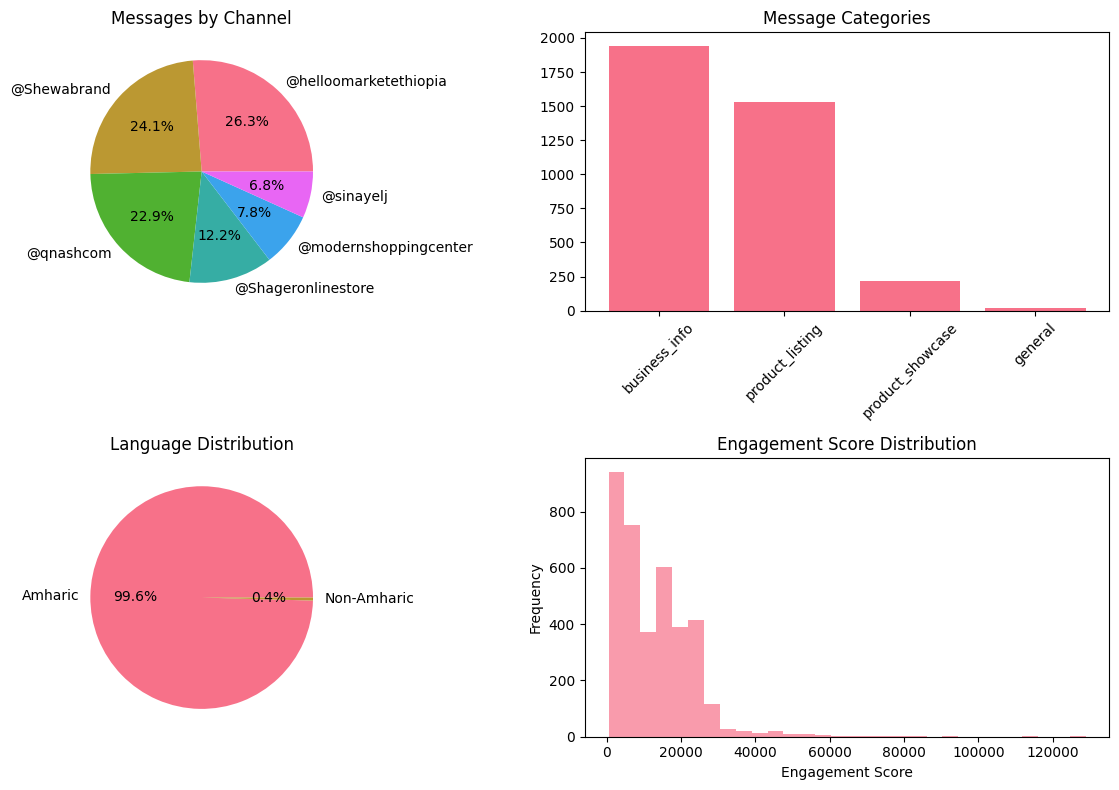


📈 SUMMARY STATISTICS:
Total messages: 3,715
Unique channels: 6
Amharic messages: 3,699 (99.6%)
Messages with prices: 1,530 (41.2%)
Messages with contact info: 3,473 (93.5%)
Messages with media: 3,695 (99.5%)

🏆 TOP CHANNELS BY MESSAGE COUNT:
  1. @helloomarketethiopia: 976 messages
  2. @Shewabrand: 895 messages
  3. @qnashcom: 850 messages
  4. @Shageronlinestore: 452 messages
  5. @modernshoppingcenter: 291 messages

📝 MESSAGE CATEGORY BREAKDOWN:
  • business_info: 1,944 messages (52.3%)
  • product_listing: 1,530 messages (41.2%)
  • product_showcase: 220 messages (5.9%)
  • general: 21 messages (0.6%)


In [14]:
# Data Analysis and Visualization
if 'df_processed' in locals() and len(df_processed) > 0:
    
    print("📊 DATA ANALYSIS & VISUALIZATION")
    print("=" * 50)
    
    # 1. Channel Distribution
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    channel_counts = df_processed['channel_username'].value_counts()
    plt.pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%')
    plt.title('Messages by Channel')
    
    # 2. Message Categories
    plt.subplot(2, 2, 2)
    category_counts = df_processed['message_category'].value_counts()
    plt.bar(category_counts.index, category_counts.values)
    plt.title('Message Categories')
    plt.xticks(rotation=45)
    
    # 3. Language Distribution
    plt.subplot(2, 2, 3)
    language_dist = df_processed['is_amharic'].value_counts()
    plt.pie([language_dist.get(True, 0), language_dist.get(False, 0)], 
            labels=['Amharic', 'Non-Amharic'], autopct='%1.1f%%')
    plt.title('Language Distribution')
    
    # 4. Engagement Score Distribution
    plt.subplot(2, 2, 4)
    plt.hist(df_processed['engagement_score'], bins=30, alpha=0.7)
    plt.title('Engagement Score Distribution')
    plt.xlabel('Engagement Score')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n📈 SUMMARY STATISTICS:")
    print(f"Total messages: {len(df_processed):,}")
    print(f"Unique channels: {df_processed['channel_username'].nunique()}")
    print(f"Amharic messages: {df_processed['is_amharic'].sum():,} ({df_processed['is_amharic'].mean()*100:.1f}%)")
    print(f"Messages with prices: {df_processed['has_price'].sum():,} ({df_processed['has_price'].mean()*100:.1f}%)")
    print(f"Messages with contact info: {df_processed['has_contact'].sum():,} ({df_processed['has_contact'].mean()*100:.1f}%)")
    print(f"Messages with media: {df_processed['has_media'].sum():,} ({df_processed['has_media'].mean()*100:.1f}%)")
    
    # Top channels by message count
    print(f"\n🏆 TOP CHANNELS BY MESSAGE COUNT:")
    for i, (channel, count) in enumerate(channel_counts.head().items(), 1):
        print(f"  {i}. {channel}: {count:,} messages")
    
    # Message category breakdown
    print(f"\n📝 MESSAGE CATEGORY BREAKDOWN:")
    for category, count in category_counts.items():
        percentage = (count / len(df_processed)) * 100
        print(f"  • {category}: {count:,} messages ({percentage:.1f}%)")
        
else:
    print("⚠️ No processed data available for analysis")
    print("Please run the data processing pipeline first.")


In [15]:
# Display sample messages
if 'df_processed' in locals() and len(df_processed) > 0:
    
    print("📝 SAMPLE MESSAGES FROM DIFFERENT CATEGORIES")
    print("=" * 60)
    
    # Show sample messages from each category
    categories = df_processed['message_category'].unique()
    
    for category in categories[:4]:  # Show first 4 categories
        print(f"\n🏷️ {category.upper()} MESSAGES:")
        print("-" * 40)
        
        category_messages = df_processed[df_processed['message_category'] == category]
        
        # Show up to 3 sample messages from this category
        for i, (idx, row) in enumerate(category_messages.head(3).iterrows()):
            print(f"\n{i+1}. Channel: {row['channel_username']}")
            print(f"   Text: {row['text'][:200]}{'...' if len(row['text']) > 200 else ''}")
            print(f"   Language: {'Amharic' if row['is_amharic'] else 'Non-Amharic'}")
            print(f"   Has Price: {row['has_price']}")
            print(f"   Has Contact: {row['has_contact']}")
            print(f"   Engagement Score: {row['engagement_score']}")
    
    # Show messages with highest engagement
    print(f"\n🔥 TOP 5 MESSAGES BY ENGAGEMENT:")
    print("-" * 40)
    
    top_engagement = df_processed.nlargest(5, 'engagement_score')
    
    for i, (idx, row) in enumerate(top_engagement.iterrows(), 1):
        print(f"\n{i}. Channel: {row['channel_username']}")
        print(f"   Text: {row['text'][:150]}{'...' if len(row['text']) > 150 else ''}")
        print(f"   Views: {row['views']:,} | Forwards: {row['forwards']} | Replies: {row['replies']}")
        print(f"   Engagement Score: {row['engagement_score']:,.0f}")
        
else:
    print("⚠️ No processed data available for sample display")


📝 SAMPLE MESSAGES FROM DIFFERENT CATEGORIES

🏷️ PRODUCT_SHOWCASE MESSAGES:
----------------------------------------

1. Channel: @helloomarketethiopia
   Text: **ሁለት **ሲገዙ **5%** ቅናሽ 
ሙሉ በሙሉ የመኝታ ቤትዎን ውበት የሚጨምር አነሶላ ለማዘዝ 8420 ይደውሉ ወይም https://t.me/helloo_market_bot?start=175610010 ይጠቀሙ! 
**መጠን: 2.40 * 1.75**
**ብዛት: ሁለት አንሶላ እና ሁለት የተራስ ልብስ**
#Madeinethiopia ...
   Language: Amharic
   Has Price: False
   Has Contact: False
   Engagement Score: 2345

2. Channel: @helloomarketethiopia
   Text: ለቤቶ አልያም ለመስሪያ ቦታዎ ደረቅ ቆሻሻ ማጠራቀሚያ  ለማዘዝ 8420 ይደውሉ ወይም https://t.me/helloo_market_bot?start=155010001 ይጠቀሙ! 
ቁጥር፦ 32* 50 ሲሜ
#Madeinethiopia #CleaningSplices #GroceryAndGourmet #Ethiopian #Marketplace #...
   Language: Amharic
   Has Price: False
   Has Contact: False
   Engagement Score: 3481

3. Channel: @helloomarketethiopia
   Text: ዘናጭ የወንዶች ሙሉ የለሊት ልብስ በተለያዩ ቀለማት ለማዘዝ 8420 ይደውሉ ወይም https://t.me/helloo_market_bot?start=124110003 ይጠቀሙ! 
Free Size 
#Madeinethiopia #MensFashion #MensCloth #Ethiopia

In [16]:
# Check for existing scraped data
raw_data_dir = PATHS['raw_data_dir']
processed_data_dir = PATHS['processed_data_dir']

# Look for combined data files
combined_files = list(raw_data_dir.glob("combined_data_*.json"))
processed_files = list(processed_data_dir.glob("processed_*.csv"))

print(f"📊 DATA AVAILABILITY CHECK")
print(f"Raw data files found: {len(combined_files)}")
print(f"Processed data files found: {len(processed_files)}")

if combined_files:
    print(f"\n📁 Latest raw data file: {combined_files[-1].name}")
elif processed_files:
    print(f"\n📁 Latest processed data file: {processed_files[-1].name}")
else:
    print(f"\n⚠️  No scraped data found. To scrape data, run:")
    print(f"   python scripts/telegram_scrapper.py")
    print(f"   or")
    print(f"   python scripts/run_data_ingestion.py")

# Create sample data if no real data is available
if not combined_files and not processed_files:
    print(f"\n🎯 Creating sample data for demonstration...")
    
    # Generate sample data
    sample_data = []
    for i, channel in enumerate(ETHIOPIAN_ECOMMERCE_CHANNELS):
        for j in range(10):  # 10 messages per channel
            sample_data.append({
                'message_id': f"{i}_{j}",
                'channel_title': f"Sample Channel {i+1}",
                'channel_username': channel,
                'text': f"Sample message {j+1} from {channel}",
                'date': datetime.now().isoformat(),
                'views': np.random.randint(10, 1000),
                'forwards': np.random.randint(0, 50),
                'replies': np.random.randint(0, 20),
                'has_media': np.random.choice([True, False]),
                'scraped_at': datetime.now().isoformat()
            })
    
    df_sample = pd.DataFrame(sample_data)
    print(f"✅ Sample dataset created with {len(df_sample)} messages")
    
else:
    # Load actual data if available
    if combined_files:
        latest_file = max(combined_files, key=lambda x: x.stat().st_mtime)
        print(f"\n📊 Loading data from: {latest_file.name}")
        
        with open(latest_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df_sample = pd.DataFrame(data)
        
    elif processed_files:
        latest_file = max(processed_files, key=lambda x: x.stat().st_mtime)
        print(f"\n📊 Loading processed data from: {latest_file.name}")
        df_sample = pd.read_csv(latest_file)

print(f"\n📈 Dataset shape: {df_sample.shape}")
print(f"🔍 Columns: {list(df_sample.columns)}")


📊 DATA AVAILABILITY CHECK
Raw data files found: 3
Processed data files found: 4

📁 Latest raw data file: combined_data_20250622_175237.json

📊 Loading data from: combined_data_20250622_175237.json

📈 Dataset shape: (6000, 16)
🔍 Columns: ['message_id', 'channel_id', 'channel_title', 'channel_username', 'text', 'date', 'views', 'forwards', 'replies', 'media_type', 'media_path', 'has_media', 'sender_id', 'is_reply', 'reply_to_msg_id', 'scraped_at']
